In [4]:
import xpress as xp
import pandas as pd
import numpy as np
import math
import json
import copy

In [5]:
note_high_table = ['VIP High Table','Centre High Table','End High Table']
df = pd.read_excel("person2.xlsx")

with open('res.json','r')  as f:
    ppl_info = json.load(f)

table_person_mapping = ppl_info['table_person_mapping']
gender = ppl_info['gender']
ppl_type = ppl_info['ppl_type']
ppl_id = ppl_info['ppl_id']
fellow_guest_mapping = ppl_info['fellow_guest_mapping']
# surname = ppl_info['surname']
note = ppl_info['note']
global_real_id = []


ppl_type_mapping = {"college guest":1,"fellow":2,"bye-fellow":3,"lecturer":4,"honorary fellow":5,"emeritus fellow":6}
table_seats = [ 21, 16, 26, 10, 20, 17 ]
table_case_idx = [2,0,1,0,0,0]

special_table_type = [1,0,1,0,0,0]
table_num = 6
END_OF_HIGH_TABLE_ID = 21 # to be corrected
BEGIN_OF_HIGH_TABLE_ID = 5 # to be corrected
output_str = ''

In [6]:
for table_id in range(table_num):
# for table_id in range(2,3):
    cur_ppl_idx = [None]
    cur_gender = [None]
    cur_ppl_type = [None]
    cur_note = [None]
    not_sit_with_guest_id = []
    # real_ppl_id = [None]
    cur_fellow_guest_mapping = []
    for index,_ in enumerate(ppl_info['table_person_mapping']):
        if ppl_info['table_person_mapping'][index][table_id] == 1:
            # real_ppl_id.append(ppl_id[index])
            cur_ppl_idx.append(index)
            cur_gender.append(ppl_info['gender'][index])
            cur_ppl_type.append(ppl_info['ppl_type'][index])
            if ppl_info['note'][index] == "Do not seat with College guests":
                not_sit_with_guest_id.append(index)
            elif ppl_info['note'][index] == "Centre High Table":
                ppl_center_high_table_id = index
            elif ppl_info['note'][index] == "End High Table":
                ppl_end_high_table_id = index


    for i,j in fellow_guest_mapping:
        if i in cur_ppl_idx:
            cur_fellow_guest_mapping.append((cur_ppl_idx.index(i),cur_ppl_idx.index(j)))

    
    model = xp.problem()
    model.controls.maxtime = 400
    num_guests = max_seats =num_seats = table_seats[table_id]
    x=np.array([[xp.var(name=f'x{i}_{k}',vartype=xp.binary) for k in range(num_seats+2)] for i in range(num_guests+2)],dtype=xp.npvar)
    model.addVariable(x)
    
    for k in range(1,num_seats+1):
        model.addConstraint(xp.Sum(x[i][k] for i in range(1,num_guests+1)) == 1)

    for i in range(1,num_guests+1): #set edge to 0
        model.addConstraint(x[i,-1]==0)
        model.addConstraint(x[i,0]==0)

    for i in range(1,num_guests+1):
       model.addConstraint(xp.Sum(x[i, k] for k in range(1,num_seats+1)) == 1)
    for i in range(1,num_guests+1):
        if cur_gender[i] == 1:
            for k in range(1,num_seats+1):
                model.addConstraint(1- x[i,k] >= xp.Sum(x[a,k-1]+x[a,k+1] for a in range(1,num_guests+1) if cur_gender[a] == 1))
        elif cur_gender[i] == -1:
            for k in range(1,num_seats+1):
                model.addConstraint(1- x[i,k] >= xp.Sum(x[a,k-1]+x[a,k+1] for a in range(1,num_guests+1) if cur_gender[a] == -1))
    
    # 4.25  fellow spread in the hall
    for i in range(1,num_guests+1):
        if cur_ppl_type[i] == 2:
            for k in range(1,num_seats+1):
                model.addConstraint(1- x[i,k] >= xp.Sum(x[a,k-1]+x[a,k+1] for a in range(1,num_guests+1) if cur_ppl_type[a] == 2))
    
    if special_table_type[table_id] == 1:
        for i in range(1,num_guests+1):
            if cur_ppl_type[i] == 2:
                model.addConstraint(x[i,1] == 0)


    if table_case_idx[table_id] == 2:
        cur_ppl_center_high_table_id = cur_ppl_idx.index(ppl_center_high_table_id)
        cur_ppl_end_high_table_id = cur_ppl_idx.index(ppl_end_high_table_id)
        model.addConstraint(x[cur_ppl_center_high_table_id,BEGIN_OF_HIGH_TABLE_ID] == 1)
        model.addConstraint(x[cur_ppl_end_high_table_id,END_OF_HIGH_TABLE_ID] == 1)
        model.addConstraint(x[i][2]==0 for i in range(1,num_guests+1) if cur_ppl_type[i] == 2)

    cur_not_sit_with_guest_id = [cur_ppl_idx.index(i) for i in not_sit_with_guest_id]
    # breakpoint()
    for i in cur_not_sit_with_guest_id:       

        for k in range(1,num_seats+1):
            model.addConstraint(3*x[i,k]<=xp.Sum(x[a,k-1] +x[a,k+1] +x[a,max_seats+1-k] for a in range(1,num_guests+1) if cur_ppl_type[a] != ppl_type_mapping["college guest"]) )
        
        k = 1
        model.addConstraint(x[i,k] ==0)

        k = max_seats
        model.addConstraint(x[i,k] ==0)

    if table_case_idx[table_id] == 0:
        for i1,i2 in cur_fellow_guest_mapping:
            for k in range(1,num_seats+1):
                model.addConstraint(x[i1,k]<= x[i2,k-1]+x[i2,k+1] +x[i2,max_seats+1-k])
                model.addConstraint(x[i2,k]<= x[i1,k-1]+x[i1,k+1] +x[i1,max_seats+1-k])
                
    if table_case_idx[table_id] == 1:    
        for i1,i2 in cur_fellow_guest_mapping:
            for k in range(1,num_seats+1):
                model.addConstraint(x[i1,k]<= x[i2,k-1]+x[i2,k+1] +x[i2,max_seats-k])
                model.addConstraint(x[i2,k]<= x[i1,k-1]+x[i1,k+1] +x[i1,max_seats-k])
                # model.addConstraint(x[i1,k] <= x[i2,k])
                # model.addConstraint(x[i2,k] <= x[i1,k])

            k= max_seats
            model.addConstraint(x[i1,k]<= x[i2,k-1] +x[i2,1])
            model.addConstraint(x[i2,k]<= x[i1,k-1] +x[i1,1])
            k=1
            model.addConstraint(x[i1,k]<= x[i2,max_seats] +x[i2,max_seats-k])
            model.addConstraint(x[i2,k]<= x[i1,max_seats] +x[i1,max_seats-k])
            
    if table_case_idx[table_id] == 2:
        k11 = [2,3,4,16,17,18,19,20]
        k12 = [6,7,8,9,10,11,12,13,14,15]
        for i1,i2 in cur_fellow_guest_mapping:   
            for k in k11:
                model.addConstraint(x[i1,k]<= x[i2,k-1]+x[i2,k+1] +x[i2,max_seats-k])
                model.addConstraint(x[i2,k]<= x[i1,k-1]+x[i1,k+1] +x[i1,max_seats-k])
            for k in k12:
                model.addConstraint(x[i1,k]<= x[i2,k-1]+x[i2,k+1] +x[i2,max_seats-1-k])
                model.addConstraint(x[i2,k]<= x[i1,k-1]+x[i1,k+1] +x[i1,max_seats-1-k])
            k=5
            model.addConstraint(x[i1,k]<= x[i2,k-1]+x[i2,k+1] +x[i2,max_seats-1-k]+x[i2,max_seats-k])
            model.addConstraint(x[i2,k]<= x[i1,k-1]+x[i1,k+1] +x[i1,max_seats-1-k]+x[i1,max_seats-k])
            
            k= max_seats
            model.addConstraint(x[i1,k]<= x[i2,k-1] +x[i2,1])
            model.addConstraint(x[i2,k]<= x[i1,k-1] +x[i1,1])

            k=1
            model.addConstraint(x[i1,k]<= x[i2,max_seats] +x[i2,max_seats-k])
            model.addConstraint(x[i2,k]<= x[i1,max_seats] +x[i1,max_seats-k])
    model.setObjective(xp.Sum(x[i,k] for i in range(1,num_guests+1) for k in range(num_seats)), sense=xp.maximize)

    model.optimize()
    res = model.getSolution(x)
    print('=========================================================')
    
    cur_output = ''
    cur_output+= f'table {table_id+1}: \n'
    guest_id = []
    for k in range(1,num_seats+1):
        for i in range(1,num_guests+1):
            if res[i,k] == 1:
                guest_id.append(i)
    guest_real_id = [cur_ppl_idx[i] for i in guest_id]
    global_real_id += [cur_ppl_idx[i] for i in guest_id]
    # cur_output += f"guests: {guest_real_id}\n"
    cur_output += f"guests:{[ppl_info['ppl_id'][i] for i in guest_real_id ]}\n"
    cur_output+= f'note:{[note[i] for i in guest_real_id]}\n'
    gender_all = []
    for i in guest_id:
        if cur_gender[i] == 1:
            gender_all.append('male')
        elif cur_gender[i] == -1:
            gender_all.append('female')
        else:
            gender_all.append('unknown')
    cur_output += f"gender: {gender_all}\n"
    # print(cur_output)
    cur_output += f"fellow_guest_mapping:{fellow_guest_mapping}\n"
    cur_output+= '=========================================================\n'
    output_str += cur_output
    print(output_str)

FICO Xpress v9.2.4, Hyper, solve started 16:10:22, Aug 21, 2024
Heap usage: 667KB (peak 667KB, 168KB system)
Maximizing MILP noname using up to 8 threads and up to 8006MB memory, with these control settings:
MAXTIME = 400
OUTPUTLOG = 1
Original problem has:
       581 rows          529 cols         4771 elements       529 entities
Presolved problem has:
       142 rows          279 cols         1179 elements       279 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 755KB (peak 1224KB, 168KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  Objective      [min,max] : [ 1.00e+00,  1.00e+00] / [      0.0,       0.0]
Autoscaling applied standard scaling

Symmetric problem: generators: 9, support set: 237
 Number of orbits: 64, largest orbit: 7
 Row orbits: 29, row support: 

table 1: 
guests:[58, 3, 80, '84(21*)', 21, '100(40*)', '85(22*)', 22, '86(24*)', 8, 24, 19, 76, 40, 20, 75, 23, 70, 15, '87(25*)', 25]
note:[None, 'VIP High Table', None, None, 'Centre High Table', None, None, 'VIP High Table', None, 'VIP High Table', 'VIP High Table', 'VIP High Table', 'Do not sear near Dr Hofmann', None, None, None, 'VIP High Table', 'Do not seat near Professor Dickens', 'VIP High Table', None, 'End High Table']
gender: ['male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown']
fellow_guest_mapping:[[21, 84], [22, 85], [24, 86], [25, 87], [26, 88], [27, 89], [29, 90], [30, 91], [31, 92], [32, 93], [33, 94], [34, 95], [35, 96], [36, 97], [38, 98], [39, 99], [40, 100], [41, 101], [42, 102], [44, 103], [45, 104], [46, 105], [48, 106], [50, 107], [52, 108], [53, 109], [56, 110]]
table 2: 
guests:[13, '101(41*)', 41, 

table 1: 
guests:[58, 3, 80, '84(21*)', 21, '100(40*)', '85(22*)', 22, '86(24*)', 8, 24, 19, 76, 40, 20, 75, 23, 70, 15, '87(25*)', 25]
note:[None, 'VIP High Table', None, None, 'Centre High Table', None, None, 'VIP High Table', None, 'VIP High Table', 'VIP High Table', 'VIP High Table', 'Do not sear near Dr Hofmann', None, None, None, 'VIP High Table', 'Do not seat near Professor Dickens', 'VIP High Table', None, 'End High Table']
gender: ['male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown']
fellow_guest_mapping:[[21, 84], [22, 85], [24, 86], [25, 87], [26, 88], [27, 89], [29, 90], [30, 91], [31, 92], [32, 93], [33, 94], [34, 95], [35, 96], [36, 97], [38, 98], [39, 99], [40, 100], [41, 101], [42, 102], [44, 103], [45, 104], [46, 105], [48, 106], [50, 107], [52, 108], [53, 109], [56, 110]]
table 2: 
guests:[13, '101(41*)', 41, 

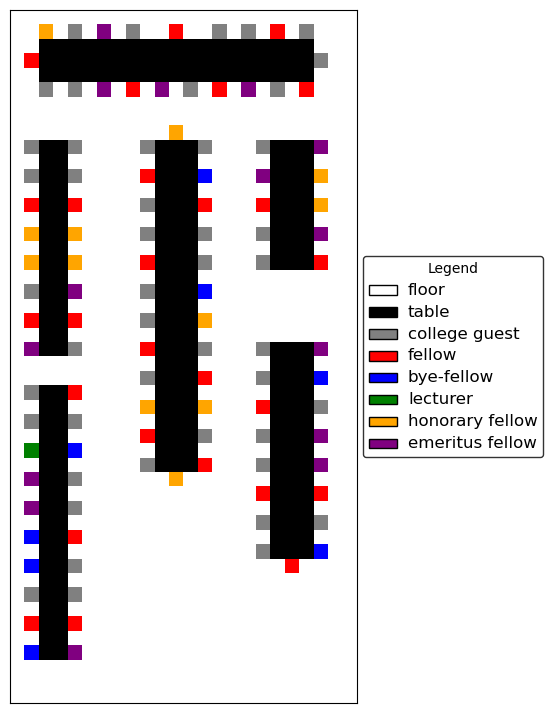

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# read file
file_path = "map110.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

matrix = df.to_numpy(dtype=np.int8)[1:,1:]
global_map = copy.deepcopy(matrix)

for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map[i,j] > 0:
            cur_ppl_id = global_map[i,j]-1
            global_map[i,j] = ppl_info["ppl_type"][global_real_id[cur_ppl_id]]


ppl_type_mapping = {"college guest":1,"fellow":2,"bye-fellow":3,"lecturer":4,"honorary fellow":5,"emeritus fellow":6,}
label_map = {
    -1:"floor",
    0:"table",
    1:"college guest",
    2:"fellow", 
    3:"bye-fellow",
    4:"lecturer",
    5:"honorary fellow",
    6:"emeritus fellow",
}

color_map = {
    -1: 'white',    
    0: 'black',     
    1: 'grey',       
    2: 'red',    
    3: 'blue',      
    4: 'green',     
    5: 'orange',    
    6: 'purple',    
}

import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_xticks([])  
ax.set_yticks([])  
ax.tick_params(axis='both', which='both', length=0)  

boundaries = sorted(color_map.keys()) + [max(color_map.keys())+1]

norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(global_map, cmap=cmap, norm=norm)

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=color_map[key], edgecolor='black', label=label_map[key])
                   for key in sorted(label_map.keys())]


leg = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=True)
leg.get_frame().set_edgecolor('black')  

for text in leg.get_texts():
    text.set_fontsize(12)  
# plt.savefig('output5.png', dpi=600)
plt.subplots_adjust(right=0.8)
plt.show()

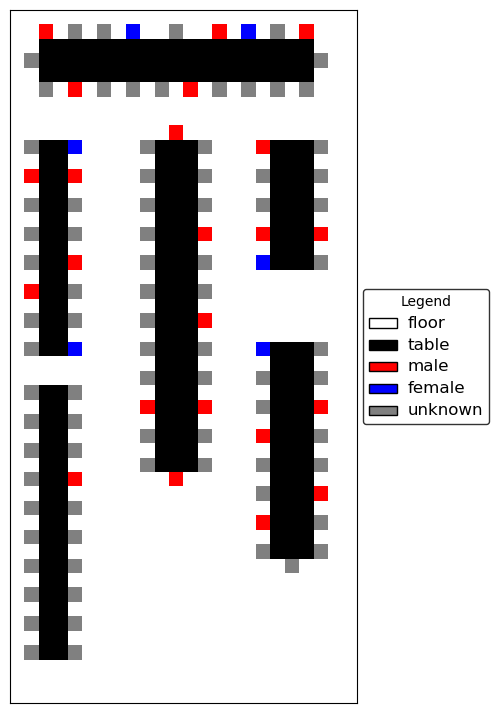

In [8]:
import matplotlib.pyplot as plt
import numpy as np

file_path = "map110.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

matrix = df.to_numpy(dtype=np.int8)[1:,1:]

global_map = copy.deepcopy(matrix)
gender = ppl_info['gender']
gender_id_to_color_id = {
    1:1,
    -1:2,
    0:3
}

for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map[i,j] > 0:
            cur_ppl_id = global_map[i,j]-1
            global_map[i,j] = gender_id_to_color_id[ppl_info["gender"][global_real_id[cur_ppl_id]]]


ppl_gender_mapping = {"male":1,"female":2,"unknown":3}


label_map = {
    -1:"floor",
    0:"table",
    1:"male",
    2:"female",
    3:"unknown" 
}

color_map = {
    -1: 'white',    
    0: 'black',     
    1: 'red',       
    2: 'blue',    
    3: 'grey',      
}

import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_xticks([])  
ax.set_yticks([])  
ax.tick_params(axis='both', which='both', length=0)  

boundaries = sorted(color_map.keys()) + [max(color_map.keys())+1]


norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(global_map, cmap=cmap, norm=norm)


from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=color_map[key], edgecolor='black', label=label_map[key])
                   for key in sorted(label_map.keys())]


leg = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=True)
leg.get_frame().set_edgecolor('black')  

for text in leg.get_texts():
    text.set_fontsize(12)  
# plt.savefig('output5.png', dpi=600)
plt.subplots_adjust(right=0.8)
plt.show()

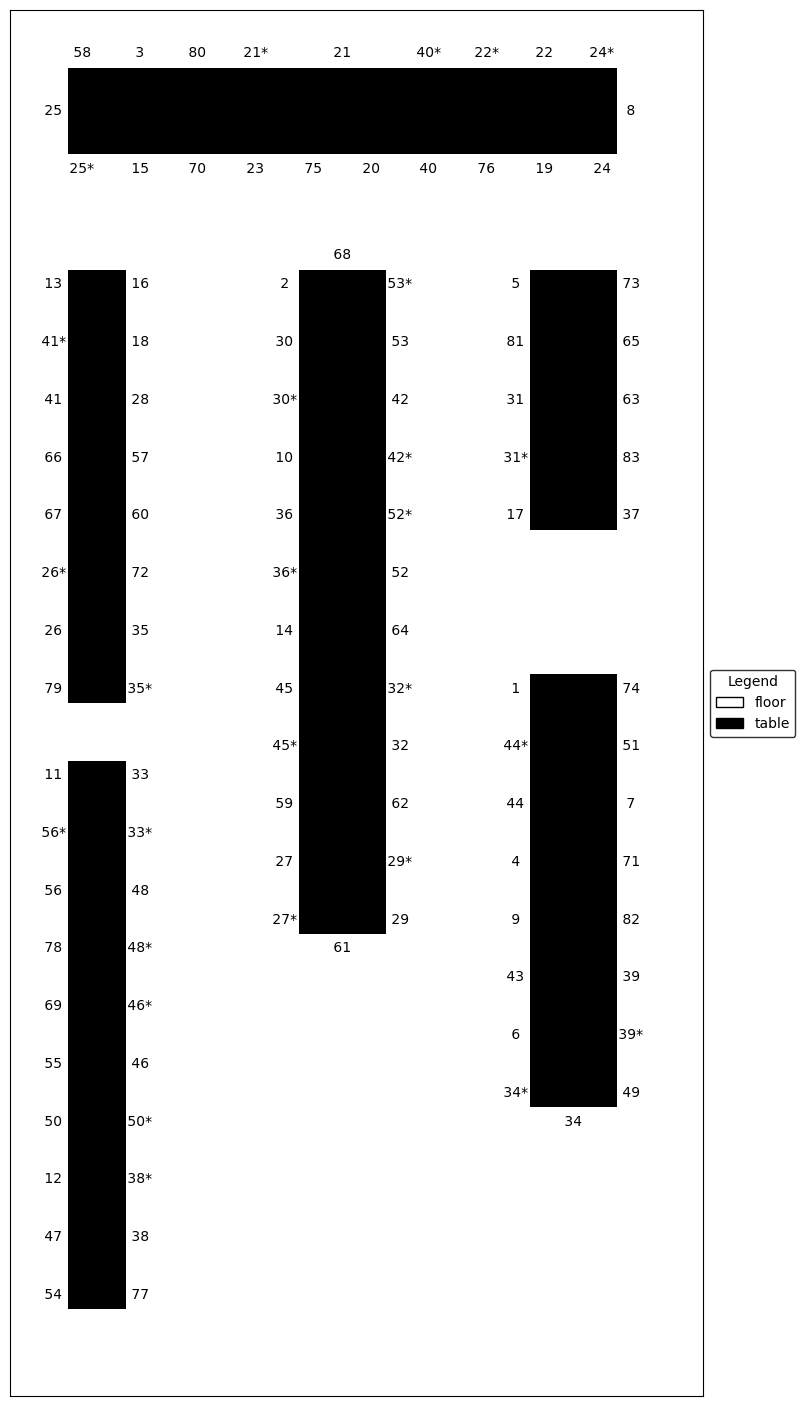

In [9]:
import re

def extract_or_return_original(input_string):
    
    pattern = r'\(([^)]*)\)'

    
    match = re.search(pattern, input_string)

    if match:
        
        return match.group(1)
    else:
        
        return input_string
    
ppl_id_str = [extract_or_return_original(str(i)) for i in ppl_info['ppl_id']]
ppl_id_str = [' '+i+' ' for i in ppl_id_str]
# print(ppl_id_str)
global_map = copy.deepcopy(matrix)
global_map_str = [['' for _ in range(global_map.shape[1])] for _ in range(global_map.shape[0])]
for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map[i,j] > 0:
            cur_ppl_id = global_map[i,j]-1
            global_map[i,j] = ppl_info["ppl_type"][global_real_id[cur_ppl_id]]

            global_map_str[i][j] = ppl_id_str[global_real_id[cur_ppl_id]]


# global_map_id  = copy.deepcopy(matrix)
# global_map_str = [['' for _ in range(global_map.shape[1])] for _ in range(global_map.shape[0])]
# for i in range(global_map_id.shape[0]):
#     for j in range(global_map_id.shape[1]):
#         if global_map_id[i,j] > 0:
#             cur_ppl_id = global_map_id[i,j]
#             # print(cur_ppl_id,ppl_id_str[cur_ppl_id])
#             global_map_str[i][j] = ppl_id_str[cur_ppl_id]    
#         else:
#             global_map_str[i][j] = ""
ppl_type_mapping = {"college guest":1,"fellow":2,"bye-fellow":3,"lecturer":4,"honorary fellow":5,"emeritus fellow":6,}
label_map = {
    -1:"floor",
    0:"table",
}

color_map = {
    -1: 'white',   
    0: 'black',     
    1: 'white',      
    2: 'white',   
    3: 'white',      
    4: 'white',     
    5: 'white',    
    6: 'white',    
}


cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])

fig, ax = plt.subplots(figsize=(30, 18))
ax.set_xticks([])  
ax.set_yticks([])  
ax.tick_params(axis='both', which='both', length=0)  

boundaries = sorted(color_map.keys()) + [max(color_map.keys()) + 1]

norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(global_map, cmap=cmap, norm=norm)

for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map_str[i][j] != '':
            ax.text(j, i, global_map_str[i][j], ha='center', va='center', fontsize=10, color='black')


legend_elements = [Patch(facecolor=color_map[key], edgecolor='black', label=label_map[key])
                   for key in sorted(label_map.keys())]


leg = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=True)
leg.get_frame().set_edgecolor('black')  

plt.subplots_adjust(right=0.8)